# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import time
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# 한글 깨짐 문제 해결용
from matplotlib import font_manager, rc
plt.rcParams["axes.unicode_minus"] = False
path = "C:\Windows\Fonts\H2GTRM.TTF"
font_name = font_manager.FontProperties(fname=path).get_name()
rc("font", family=font_name)

# 1. Data

In [3]:
rg3 = pd.read_csv("data/processed/labeled_data_KAMP_rg3_1.csv", parse_dates=True)

In [4]:
rg3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                1256 non-null   int64  
 1   Injection_Time            1256 non-null   float64
 2   Filling_Time              1256 non-null   float64
 3   Plasticizing_Time         1256 non-null   float64
 4   Cycle_Time                1256 non-null   float64
 5   Clamp_Close_Time          1256 non-null   float64
 6   Cushion_Position          1256 non-null   float64
 7   Switch_Over_Position      1256 non-null   float64
 8   Plasticizing_Position     1256 non-null   float64
 9   Max_Injection_Speed       1256 non-null   float64
 10  Max_Screw_RPM             1256 non-null   float64
 11  Average_Screw_RPM         1256 non-null   float64
 12  Max_Injection_Pressure    1256 non-null   float64
 13  Max_Switch_Over_Pressure  1256 non-null   float64
 14  Max_Back

# 2. 학습/평가 데이터 분리를 위한 데이터 전처리

In [5]:
rg3["PassOrFail"].value_counts()

0    1224
1      32
Name: PassOrFail, dtype: int64

In [6]:
# 양품
rg3_Y = rg3[rg3["PassOrFail"] == 0]
print("rg3의 양품 개수:", len(rg3_Y))

rg3의 양품 개수: 1224


In [7]:
# 불량
rg3_N = rg3[rg3["PassOrFail"] == 1]
print("rg3의 불량 개수:", len(rg3_N))

rg3의 불량 개수: 32


**잡음 제거 오토인코더 모델에 학습시킬 데이터의 형태는 클래스 변수가 없어야 하므로 변수 "PassOrFail"을 제거함

In [8]:
# 양품
rg3_Y = rg3_Y.drop(columns=["PassOrFail"], axis=1)
# 불량
rg3_N = rg3_N.drop(columns=["PassOrFail"], axis=1)

In [9]:
# MinMaxscaler를 통한 데이터 정규화

scaler = MinMaxScaler()

rg3_Y = scaler.fit_transform(rg3_Y)
rg3_N = scaler.fit_transform(rg3_N)

#### 학습/평가 데이터 분리 (6:4 비율)

In [10]:
rg3_Y.shape

(1224, 24)

In [11]:
# 학습 데이터 (양품)
rg3_train_Y = rg3_Y[:754]

# 평가 데이터 (양품)
rg3_test_Y = rg3_Y[754:]

# 평가 데이터 (불량)
rg3_test_N = rg3_N

print(f"rg3 학습 데이터 (양품) 개수: {len(rg3_train_Y)}")
print(f"rg3 평가 데이터 (양품) 개수: {len(rg3_test_Y)}")
print(f"rg3 평가 데이터 (불량) 개수: {len(rg3_test_N)}")

rg3 학습 데이터 (양품) 개수: 754
rg3 평가 데이터 (양품) 개수: 470
rg3 평가 데이터 (불량) 개수: 32


# 3. Mahalanobis Distance

In [12]:
def mahalanobis(x=None, data=None, cov=None):
    """
    Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data, axis=0)
    if not cov:
        cov = np.cov(data.T)
        # cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()  # Can't understand why .diagonal() is used

In [13]:
class MahalanobisOneclassClassifier():
    def __init__(self, xtrain, significance_level=0.01):
        self.xtrain = xtrain
        self.critical_value = chi2.ppf((1-significance_level), df=xtrain.shape[1] - 1) # df = degree of freedom
        print('Critical value is: ', self.critical_value)

    def predict_proba(self, xtest):
        mahalanobis_dist = mahalanobis(xtest, self.xtrain)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, xtest):
        return np.array([int(i) for i in self.predict_proba(xtest) > self.critical_value])

# 4. 임계값 정의

In [14]:
clf = MahalanobisOneclassClassifier(rg3_train_Y, significance_level=0.01)

Critical value is:  41.638398118858476


In [15]:
# threshold = clf.critical_value
threshold = 180

# 5. 데이터 각각의 예측값과 복원 오차 확인

## 5.1. 평가 데이터 (양품) 대상 모델 성능 검증 

In [16]:
# 예측값
rg3_MD_Y = clf.predict_proba(rg3_test_Y)

In [17]:
rg3_MD_Y.shape

(470,)

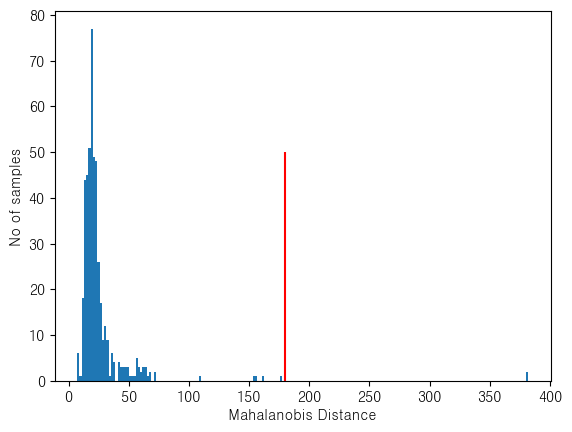

In [18]:
# 시각화

plt.hist(rg3_MD_Y, bins=200)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(threshold, 0, 50, color="red")
plt.show();

In [19]:
# 불량으로 판단한 데이터 확인

rg3_test_Y_anomalies = rg3_MD_Y > threshold
print("불량 개수: ", np.sum(rg3_test_Y_anomalies))
print("정확도: ", (rg3_test_Y.shape[0]-np.sum(rg3_test_Y_anomalies))/rg3_test_Y.shape[0])

불량 개수:  2
정확도:  0.9957446808510638


## 5.2. 평가 데이터 (불량) 대상 모델 성능 검증 

In [20]:
# 예측값
rg3_MD_N = clf.predict_proba(rg3_test_N)

In [21]:
rg3_MD_N

array([ 183.03204329,  200.75596009,  216.60720341,  218.67202955,
        159.05091943, 2496.0960975 , 1694.79049368, 2427.41422883,
       2211.26697466, 2790.32640797, 1952.26023328, 1843.55539879,
       2113.86600561, 2020.08358999, 2348.18249055, 2371.95570759,
       1707.74932524, 1849.01839592, 1632.07603772, 1798.83394828,
       1471.56541817, 1659.97954973, 1402.71413601, 1504.57133202,
       1800.40510055, 1242.06133986, 1794.45761994, 1583.32608492,
       1660.93911024, 1161.98793712,  364.22339028,  243.82611062])

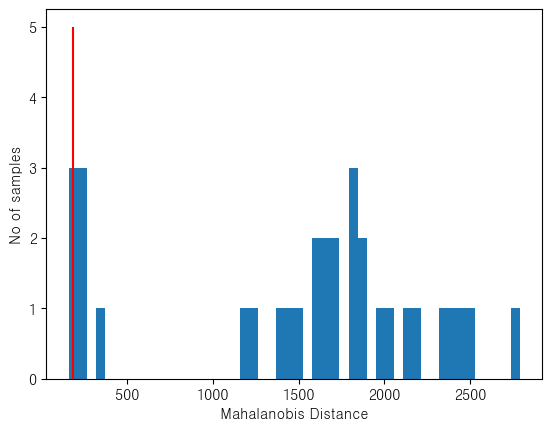

In [22]:
# 시각화

plt.hist(rg3_MD_N, bins=50)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(threshold, 0, 5, color="red")
plt.show();

In [23]:
# 불량으로 판단한 데이터 확인

rg3_test_N_anomalies = rg3_MD_N > threshold
print("불량 개수: ", np.sum(rg3_test_N_anomalies))
print("정확도: ", np.sum(rg3_test_N_anomalies)/rg3_test_N.shape[0])

불량 개수:  31
정확도:  0.96875


# 6. 결과 분석

In [24]:
# 평가 데이터의 실제값

rg3_true = np.concatenate(
    [np.zeros(len(rg3_test_Y_anomalies)), np.ones(len(rg3_test_N_anomalies))]
)

In [25]:
rg3_true.shape

(502,)

In [26]:
# 평가 데이터의 예측값

rg3_prediction = np.concatenate(
    [rg3_test_Y_anomalies, rg3_test_N_anomalies]
)

In [27]:
rg3_prediction.shape

(502,)

In [28]:
confusion_matrix(rg3_true, rg3_prediction)

array([[468,   2],
       [  1,  31]], dtype=int64)

In [29]:
print(classification_report(rg3_true, rg3_prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       470
         1.0       0.94      0.97      0.95        32

    accuracy                           0.99       502
   macro avg       0.97      0.98      0.98       502
weighted avg       0.99      0.99      0.99       502

